# Sentiment Analysis of Twitter Posts

<!-- Notebook name goes here -->
<center><b>Notebook: Data Description, Cleaning, Exploratory Data Analysis, and Preprocessing</b></center>
<br>

**by**: Stephen Borja, Justin Ching, Erin Chua, and Zhean Ganituen.

**dataset**: Hussein, S. (2021). Twitter Sentiments Dataset [Dataset]. Mendeley. https://doi.org/10.17632/Z9ZW7NT5H2.1

**motivation**: Every minute, social media users generate a large influx of textual data on live events. Performing sentiment analysis on this data provides a real-time view of public perception, enabling quick insights into the general population’s opinions and reactions.

**goal**: By the end of the project, our goal is to create and compare supervised learning algorithms for sentiment analysis.

### **dataset description**

The Twitter Sentiments Dataset is a dataset that contains nearly 163k tweets from Twitter. The time period of when these were collected is unknown, but it was published to Mendeley Data on May 14, 2021 by Sherif Hussein of Mansoura University.

Tweets were extracted using the Twitter API, but the specifics of how the tweets were selected are unmentioned. The tweets are mostly English with a mix of some Hindi words for code-switching <u>(El-Demerdash., 2021)</u>. All of them seem to be talking about the political state of India. Most tweets mention Narendra Modi, the current Prime Minister of India.

Each tweet was assigned a label using TextBlob's sentiment analysis <u>(El‑Demerdash, Hussein, & Zaki, 2021)</u>, which assigns labels automatically.

Twitter_Data

- **`clean_text`**: The tweet's text
- **`category`**: The tweet's sentiment category

What each row and column represents: `each row represents one tweet.` <br>
Number of observations: `162,980`

---

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Code-switching is the practice of alternating between two languages $L_1$ (the native language) and $L_2$ (the source language) in a conversation. In this context, the code-switching is done to appear more casual since the conversation is done via Twitter (now, X).


# **1. Project Set-up**

We set the global imports for the projects (ensure these are installed via uv and is part of the environment). Furthermore, load the dataset here.


In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import os
import sys
from wordcloud import WordCloud
from imblearn.under_sampling import RandomUnderSampler

# Set tqdm to pandas
tqdm.pandas()

# Use lib directory
sys.path.append(os.path.abspath("../lib"))

# Imports from lib files
from janitor import *
from lemmatize import lemmatizer
from boilerplate import stopwords_set
from bag_of_words import BagOfWordsModel

# Pandas congiruation
pd.set_option("display.max_colwidth", None)

# Load raw data file
df = pd.read_csv("../data/Twitter_Data.csv")

# **2. Data Cleaning**

This section discusses the methodology for data cleaning.


As to not waste computational time, a preliminary step is to ensure that no **`NaN`** or duplicate entries exist before the cleaning steps. We can call on `info()` after each step to see the rows changed in our DataFrame


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


There are clear inconsistencies with the amount of non-null values between column **`clean_text`** and **`category`** versus the total entries, so our first step would be to drop the `NaN` entries. We can first check which rows have **`category`** as **`NaN`**.


In [132]:
NaN_rows = df[df.isna().any(axis=1)]
NaN_rows

,clean_text,category
148,NaN,0.0
130448,the foundation stone northeast gas grid inaugurated modi came major,NaN
155642,dear terrorists you can run but you cant hide are giving more years modi which you won’ see you,NaN
155698,offense the best defence with mission shakti modi has again proved why the real chowkidar our,NaN
155770,have always heard politicians backing out their promises but modi has been fulfilling his each every,NaN
158693,modi government plans felicitate the faceless nameless warriors india totally deserved,NaN
158694,NaN,-1.0
159442,chidambaram gives praises modinomics,NaN
159443,NaN,0.0
160559,the reason why modi contested from seats 2014 and the real reason why rahul doing the same now,NaN


We found that there were a total of 11 rows that have **`NaN`** values, thus we drop them to ensure the integrity and accuracy of our data analysis.


In [133]:
df = df.dropna()
NaN_rows = df[df.isna().any(axis=1)]
NaN_rows

,clean_text,category


Another issue found commonly in real-world datasets would be duplicate rows, often from manual data entry errors, system glitches, or when merging data from multiple, overlapping sources. We can first check for duplicates in our `DataFrame` then remove them.


In [134]:
duplicate_rows = df[df.duplicated()]
duplicate_rows

,clean_text,category


There exist no duplicate rows within our `DataFrame`.


By converting a CSV file into a DataFrame, pandas automatically defaults numeric values to `float64` when it encounters decimals or **`NaN`** types. Text of `str` type get inferred and loaded into a `object` as the generic type for strings. We can check the dtype of our `DataFrame` columns through [`info()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html)


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


We can see that **`clean_text`** column dtype is of `object` and category is of dytpe `float64`, to determine if the columns are assigned the right data type we check the unqiue values in each column.


In [136]:
for item in df["category"].unique():
    print(item)

-1.0
0.0
1.0


In [137]:
for item in df["clean_text"].unique()[:3]:
    print(item)

when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
talk all the nonsense and continue all the drama will vote for modi 
what did just say vote for modi  welcome bjp told you rahul the main campaigner for modi think modi should just relax


Now that we have seen the unique values of each column, we can safely say that the data types assigned to both columns were not the right ones.


We first will convert column **`category`** from `float64` to `int64` considering that the range of values (**`-1`**, **`0`**, **`1`**) for a tweet's sentiment category will only ever be whole numbers. This step is done after dropping **`NaN`** value rows because **`NaN`** is fundamentally a float type.


In [138]:
df["category"] = df["category"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  object
 1   category    162969 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


After successfully converting the **`category`** column into `int64`, next we convert column `clean_string` from `object` type into the pandas defined `string` type for consistency and better performance.


In [139]:
df["clean_text"] = df["clean_text"].astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  string
 1   category    162969 non-null  int64 
dtypes: int64(1), string(1)
memory usage: 3.7 MB


We are now finished with the _initial_ data cleaning steps, this level is more focused on the standard or common issues present in public datasets and the cleaning of it before we move onto our main cleaning pipeline, which would be more focused on cleaning the tweets themselves.


## **Main Cleaning Pipeline**

We follow a similar methodology for data cleaning presented in (George & Murugesan, 2024).


### **Normalization**

Due to the nature of the text being tweets, the presence of emojis and accented characters are to be expected. To see if our data has these special characters, we selected a sample set of them to be displayed if they were in **`clean_text`**.


In [140]:
# Finding a sample of rows with emojis
rows_with_emojis = df[df["clean_text"].str.contains(r"[\u263a-\U0001f645]", regex=True)]
rows_with_emojis["clean_text"].sample(5)

75330                                                                                                                              maybe she did for votesbut confirmisnt she dead citing this examplewhat trying provethat modi did for votes tooo‍♂️
97485                                                                                                                    sent his sister defeat sent his sister kill kashyp sent his sister kill gandhi sent his sister defeat history repeats\n✌️✌️✌️
143978                        yep can confirm the same\n2017 firstmodicriminals directly listed here chennai india️hostage trying their tricks\nthengss used the organized gangstalkers groups funded got screenshots them well reportsnon action too️
149506                                                                                                                                                                                                          yesonce again modi ✌️ vote for modi ✌️
136415    ho

In [141]:
# Finding a sample of rows with accented characters
accented_char_rows = df[df["clean_text"].str.contains(r"É|é|Á|á|ó|Ó|ú|Ú|í|Í")]
accented_char_rows["clean_text"].sample(5)

59831                                                                                                                                       india shoots down satellite test modi hails arrival space power vía 
69828                                                                                                                                    indias election commission examining modi address antimissile test vía 
143649    when was home for christmasi was staggeredno pun intended the price amstel and other lagers these are the prices was paying bon marchébond stmtpleasant skies was bit cheaper kwa raj modi’ liqour hub
135134                                                                                         déjà says judge during nirav modis court hearing remembers the time she ordered vijay mallyas extradition india\n
23047                                                                                                      unlikely titfortat istan darpok nikammé babus chorriforri

Although in a real-world context these do serve as a form of emotional expression, they provide no relevance towards _textual_ sentiment analysis, thus we normalize the text.


To normalize the text, the `normalize` function was created. It normalizes the text input to ASCII-only characters (say, "cómo estás" becomes "como estas") and lowercased alphabetic symbols. The dataset contains Unicode characters (e.g., emojis and accented characters) which the function replaces to the empty string (`''`).


In [142]:
normalize??

Signature: normalize(text: str) -> str
Source:   
def normalize(text: str) -> str:
    """
    Normalize text from a pandas entry to ASCII-only lowercase characters. Hence, this removes Unicode characters with no ASCII
    equivalent (e.g., emojis and CJKs).

    Do not use this function alone, use `clean_and_tokenize()`.

    # Parameters
    * text: String entry.

    # Returns
    ASCII-normalized text containing only lowercase letters.

    # Examples
    normalize("¿Cómo estás?")
    $ 'como estas?'

    normalize(" hahahaha HUY! Kamusta 😅 Mayaman $$$ ka na ba?")
    $ ' hahahaha huy! kamusta  mayaman $$$ ka na ba?'
    """
    normalized = unicodedata.normalize("NFKD", text)
    ascii_text = normalized.encode("ascii", "ignore").decode("ascii")

    return ascii_text.lower()
File:      a:\college\year 3\term 2\stintsy\stintsy-order-of-erin\lib\janitor.py
Type:      function

### **Punctuations**

Punctuations are part of natural speech and reading to provide a sense of structure, clarity, and tone to sentences, but in the context of a classification study, punctuations do not add much information to the sentiment of a message. The sentiment of `i hate you!` and `i hate you` are going to be the same despite the punctuation mark `!` being used to accentuate the sentiment. We can see a sample of rows with punctations below.


In [143]:
# Finding a sample of rows with punctuation
rows_with_punc = df[df["clean_text"].str.contains(r"[^\w\s]")]
rows_with_punc["clean_text"].sample(5)

116004                                                                                                                                                                               nirav modi’ bail plea rejected london court for second time 
154083    modi says “ even when pakis counting the dead bodies opposition asking for proof”modi born liar what wrong ask for how many are dead called attack who are you modi you don’ know are still people’ democracy people for people people 
74562                                                                                                                                                             india’ narendra modi projects military might testing antisatellite missile via 
155981                                                         some left leaning urban naxals called film makers  have signed petition again the modi government coming power again\nbut you know what the billion common indians are with him ❤ 
55356                           

To address this, the function `rem_punctuation` was made, which replaces all punctuations and special characters with an empty string (`''`)


In [144]:
rem_punctuation??

Signature: rem_punctuation(text: str) -> str
Source:   
def rem_punctuation(text: str) -> str:
    """
    Removes the punctuations. This function simply replaces all punctuation marks and special characters
    to the empty string. Hence, for symbols enclosed by whitespace, the whitespace are not collapsed to a single whitespace
    (for more information, see the examples).

    Do not use this function alone, use `clean_and_tokenize()`.

    # Parameters
    * text: String entry.

    # Returns
    Text with the punctuation removed.

    # Examples
    rem_punctuation("this word $$ has two spaces after it!")
    $ 'this word  has two spaces after it'

    rem_punctuation("these!words@have$no%space")
    $ 'thesewordshavenospace'
    """
    return re.sub(f"[{re.escape(string.punctuation)}]", "", text)
File:      a:\college\year 3\term 2\stintsy\stintsy-order-of-erin\lib\janitor.py
Type:      function

### **Numbers**

Similar to punctuations, numbers do not add any information to the sentiment of a message.


In [145]:
# Finding a sample of rows that contain numbers
rows_with_numbers = df[df["clean_text"].str.contains(r"\d")]
rows_with_numbers["clean_text"].sample(5)

80740                                     the 130 crore indians have decided that will phir baar modi sarkar years ago when sought your blessings you gave lot love had said that will return with interest narendra modi meerut source  
98439                                                      yes and said parliament there were operational airports 2014 the larger point modi operationalized airports neither 100s claimed you nor claimed feku yes larger point stands 
115023                                                                                                                                  priyanka gandhi lies about mgnrega target the modi government here are the facts\nां्ेााा2019चुा 
117709                                                                                                you wrong dear friend was 1975 aur aap 2019 1975 compare kar the modi gali dekar strange sir aap the nhi 1975 liye compare kar the 
151746    was seat varnasi coz modi had sitting seat until 2014w

Hence, we defined the `rem_numbers` as a function that replaces all numerical values as an empty string (`''`).


In [146]:
rem_numbers??

Signature: rem_numbers(text: str) -> str
Source:   
def rem_numbers(text: str) -> str:
    """
    Removes numbers. This function simply replaces all numerical symbols to the empty string. Hence, for symbols enclosed by
    whitespace, the whitespace are not collapsed to a single whitespace (for more information, see the examples).

    Do not use this function alone, use `clean_and_tokenize()`.

    # Parameters
    * text: String entry.

    # Returns
    Text with the numerical symbol removed

    # Examples
    rem_numbers(" h3llo, k4must4 k4  n4?")
    ' hllo, kmust k  n?'
    """
    return re.sub(r"\d+", "", text)
File:      a:\college\year 3\term 2\stintsy\stintsy-order-of-erin\lib\janitor.py
Type:      function

### **Whitespace**

Similar to punctations, whitespaces do not add any information to the text and are from user errors. We check if our data has whitespace.


In [147]:
# Finding a sample of rows that contain 2 or more whitespaces in a row
rows_with_whitespaces = df[df["clean_text"].str.contains(r"\s{2,}")]
rows_with_whitespaces["clean_text"].sample(5)

50010                                                                                                              arey really misunderstood your account sorry boss  the wire idiot nair and quint dono info anti modi hain soanyway now air clear ✌️✌️
58874     ohh really then why displaying your photo dont you want people notice you and give you compliments\njust because its done under modis era you pseduosecular bigots have gone nuts \ndont know what will happen wins 2019 with more margin wish
157120                                                      modi should apologise entire nation full report card modi out now you will shocked see how india has changed last years  india now suffering from highest unemployment rate years nsso data 
48263                                                 congratulations india key liya garv key bat hai hum world par numbar par gai hai she jada khushi key bat hamare liye kuch bhi nahi hai only bjp priam minister modi jiiii love you all you\n\n\n\n
4902

Thus to address the problem, the function `collapse_whitespace` was made, which collapses all whitespace characters to a single space. Formally, it is a transducer

$$
\Box^+ \mapsto \Box \qquad \text{where the space character is } \Box
$$

Informally, it replaces all strings of whitespaces to a single whitespace character.


In [148]:
collapse_whitespace??

Signature: collapse_whitespace(text: str) -> str
Source:   
def collapse_whitespace(text: str) -> str:
    """
    This collapses whitespace. Here, collapsing means the transduction of all whitespace strings of any
    length to a whitespace string of unit length (e.g., "   " -> " "; formally " "+ -> " ").

    Do not use this function alone, use `clean_and_tokenize()`.

    # Parameters
    * text: String entry.

    # Returns
    Text with the whitespaces collapsed.

    # Examples
    collapse_whitespace("  huh,  was.  that!!! ")
    $ 'huh, was. that!!!'
    """
    return re.sub(" +", " ", text).strip()
File:      a:\college\year 3\term 2\stintsy\stintsy-order-of-erin\lib\janitor.py
Type:      function

To seamlessly call all these cleaning functions, we have the `clean` function that acts as a container that calls these separate components. The definition of this wrapper function is quite long, see [this appendix](#appendix:-clean-wrapper-function-definition) for its definition.

We can now clean the dataset and store it in a new column named `clean_ours` (to differentiate it with the, still dirty, column `clean_text` from the dataset author)


In [149]:
df["clean_ours"] = df["clean_text"].map(clean).astype(dtype="string")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  string
 1   category    162969 non-null  int64 
 2   clean_ours  162969 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


To confirm if the character cleaning worked, we can check for the differences between `clean_text` and `clean_ours` from the filtered rows below and compare the differences.


In [150]:
example_rows = df[
    df["clean_text"].str.contains(r"\s{2,}|\d|[^\w\s]|[\u263a-\U0001f645]|[ÉéÁáóÓúÚíÍ]")
]
example_rows.sample(10)

,clean_text,category,clean_ours
147433,fakendra modi and ambani brothers are both chor chor mausere bhai fakendra modi says them bjp bhagao aur desh bachao shan congress lao shan please dont forget remove fakendra modi editorji ीिो ेें\n,0,fakendra modi and ambani brothers are both chor chor mausere bhai fakendra modi says them bjp bhagao aur desh bachao shan congress lao shan please dont forget remove fakendra modi editorji
60830,bjp and modi satellite channel drum about scientific achievement party achievement arnab patrons will shown the door 2019,0,bjp and modi satellite channel drum about scientific achievement party achievement arnab patrons will shown the door
159355,modi’ vulnerable domestic flank,-1,modi vulnerable domestic flank
43700,nirav modi was arrested the scotland yard last week and was produced before court london which had rejected his bail plea will remain custody till march 2019,0,nirav modi was arrested the scotland yard last week and was produced before court london which had rejected his bail plea will remain custody till march
117114,orchestrated 1000 hitjobs modishah but congi ldr made niajudgetakes cake,0,orchestrated hitjobs modishah but congi ldr made niajudgetakes cake
96831,drdo exchief mission shakti upa didn’ give nod but had the courage,0,drdo exchief mission shakti upa didn give nod but had the courage
19162,cong and that too ’ fake leader says not jumla middle class and rich have foot this bill now all income tax concessions would drying out demand killing investment further like cong govt’ stopped modi care foot their loan waivers too goes same way,-1,cong and that too fake leader says not jumla middle class and rich have foot this bill now all income tax concessions would drying out demand killing investment further like cong govt stopped modi care foot their loan waivers too goes same way
38804,writes rail aviation ministries questioning use narendra modi’ image tickets…,0,writes rail aviation ministries questioning use narendra modi image tickets
160250,from both are you clear now all regional parties took ayog softness inc the past under even regional parties get the heat don’ think removing modi means only fight bjp ’ all round fight revive congress and remove bjp,-1,from both are you clear now all regional parties took ayog softness inc the past under even regional parties get the heat don think removing modi means only fight bjp all round fight revive congress and remove bjp
129832,schedule shri narendra modis mega rallies arunachal pradesh and assam march 2019,0,schedule shri narendra modis mega rallies arunachal pradesh and assam march


We are now finished with basic text cleaning, but the data cleaning does not end here. Given that the text is sourced from Twitter, it includes characteristics, such as spam and informal expressions, which are not addressed by basic cleaning methods. As a result, we move on to further cleaning tailored to the nature of Twitter data.


### **Spam, Expressions, Onomatopoeia, etc.**

Since the domain of the corpus is Twitter, spam (e.g., `bbbb`), expressions (e.g., `bruhhhh`), and onomatopoeia (e.g., `hahahaha`) may become an issue by the vector representation step. Hence we employed a simple rule-based spam removal algorithm.

We remove words in the string that contains the same letter or substring thrice and consecutively. These were done using regular expressions:

$$
\text{same\_char\_thrice} := (.)\textbackslash1^{\{2,\}}
$$

and

$$
\text{same\_substring\_twice} := (.^+)\textbackslash1^+
$$

Furthermore, we also remove any string that has a length less than three, since these are either stopwords (that weren't detected in the stopword removal stage) or more spam.

Finally, we employ adaptive character diversity threshold for the string $s$.

$$
\frac{\texttt{\#\_unique\_chars}(s)}{|s|} < 0.3 + \left(\frac{0.1 \cdot \text{min}(|s|, 10)}{10}\right)
$$

It calculates the diversity of characters in a string; if the string repeats the same character alot, we expect it to be unintelligible or useless, hence we remove the string.

The definition of this wrapper function is quite long, see its definition in [this appendix](#appendix:-find_spam_and_empty-wrapper-function-definition).

Let's first look at a random sample of 10 entries from the dataset that will be modified by the function.


In [151]:
affected = df[df["clean_ours"].apply(spam_affected)]
affected_sample = affected["clean_ours"].sample(10)
affected_sample

64021                                                                                                                              sir all the best this country needs ppl like you dont know what made modi appoint advocate
100099    every village india has electricity after independence\nindia becomes the super solar power creating mw solar energy\npower modipassed yoga day just days make india creating jobs and give opportunity young minds
130945                                          then why does jp doraemon ask for rafale deal details public isnt that state secret\nonly fool will try disclose public\nhypocrites time all will tihar under osa during modi
66282                                                                                                                             thanks but dont wish now bro expecting huge bday gift modishah may rd \ntill then lots work
81876                                                                                                           

Let's now call this function on the `clean_ours` column of the dataset.


In [152]:
df["clean_ours"] = df["clean_ours"].map(find_spam_and_empty).astype("string")

To confirm if the function was able to do remove all the spammy substrings, we can check `before` and `after` to compare their differences.


In [153]:
comparison = pd.DataFrame({"before": affected_sample, "after": df["clean_ours"]})

changed = comparison[comparison["before"] != comparison["after"]]
changed.sample(10)

,before,after
130945,then why does jp doraemon ask for rafale deal details public isnt that state secret\nonly fool will try disclose public\nhypocrites time all will tihar under osa during modi,then why does doraemon ask for rafale deal details public isnt that state secret only fool will try disclose public hypocrites time all will tihar under osa during modi
95979,thats what modi did \nrararara achhe din aayenge,thats what modi did achhe din
17043,some how cong wants stop modi wave want your thought perculate ppl india especially the poor modi was cong power cud not stop modi wave cong think cud stop modi wave where modi cong out power quit,some how cong wants stop modi wave want your thought perculate india especially the poor modi was cong power cud not stop modi wave cong think cud stop modi wave where modi cong out power quit
131015,modi lac deposit\nmsp double crore jobs \npetrol prices reduction during bharat bandh drama dollar \ngareeb hatao but wealth goes modis maliks \nghi index are rock bottom \nnimo cr loot,modi lac deposit msp double crore jobs petrol prices reduction during bharat bandh drama dollar gareeb hatao but wealth goes modis maliks ghi index are rock bottom nimo loot
81876,missiles jane hai pokistan mebus usi bandw search kar rahe the modi jifinally aap mil gaye ready jao,missiles jane hai pokistan mebus usi bandw search kar rahe the modi jifinally mil gaye ready jao
17780,dude you are saying but not reading yourself not supporting what modi may have done but here are some simple facts rahul proposes k proposed bjp all poor people poor farmers,dude you are saying but not reading yourself not supporting what modi may have done but here are some simple facts rahul proposes proposed bjp all poor people poor farmers
64021,sir all the best this country needs ppl like you dont know what made modi appoint advocate,sir all the best this country needs like you dont know what made modi appoint advocate
100099,every village india has electricity after independence\nindia becomes the super solar power creating mw solar energy\npower modipassed yoga day just days make india creating jobs and give opportunity young minds,every village india has electricity after independence india becomes the super solar power creating solar energy power modipassed yoga day just days make india creating jobs and give opportunity young minds
53330,well said doubt good leader like modi can make india developed country like singapur and nalayak leader like pappu can turn same india into venezuela give atleast years modi make india super power no,well said doubt good leader like modi can make india developed country like singapur and nalayak leader like pappu can turn same india into venezuela give atleast years modi make india super power
66282,thanks but dont wish now bro expecting huge bday gift modishah may rd \ntill then lots work,thanks but dont wish now bro expecting huge bday gift modishah may till then lots work


Let’s examine whether applying this function has caused any significant changes to the DataFrame structure, given that it can convert entire cells to `NaN`.


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  string
 1   category    162969 non-null  int64 
 2   clean_ours  162942 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


The DataFrame structure is intact, but **`clean_ours`** now has 27 fewer non-null values, reflecting cells that were entirely filtered out as spam as seen below.


In [155]:
spam_rows = df[df["clean_ours"].isna()]
spam_rows[["clean_text", "clean_ours"]]

,clean_text,clean_ours
21806,bjpmpsubramanianswamyiamchowkidarcampaignpmmodi,<NA>
21855,terrorfundinghurriyatleaderspropertyseizedhafizsaeedmodigovt,<NA>
24148,pmnarendramodirequestsofexservicemanindianarmyhavildarombirsinghsharma9258,<NA>
35636,2019,<NA>
35866,‍,<NA>
35968,whattttttt,<NA>
37837,allllll,<NA>
40587,1145am,<NA>
40977,⌚1145 ❤,<NA>
48127,birthdaaaaaay,<NA>


## **Post-Cleaning Steps**

At some point during the cleaning stage, some entries of the dataset could have been reduced to `NaN` or the empty string `""`, or we could have introduced duplicates again. So, let's call `dropna` and `drop_duplicates` again to finalize the cleaning stage.


In [156]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162942 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162942 non-null  string
 1   category    162942 non-null  int64 
 2   clean_ours  162942 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


In [157]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162942 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162942 non-null  string
 1   category    162942 non-null  int64 
 2   clean_ours  162942 non-null  string
dtypes: int64(1), string(2)
memory usage: 5.0 MB


# **3. Exploratory Data Analysis and Pre-processing**

With the dataset cleaned and ready for analysis, the next step is to explore its characteristics. Exploratory Data Analysis (EDA) uncovers patterns, highlights anomalies, and reveals feature distributions, and insights that guide how we prepare the data and which models might perform best.


We begin by analyzing the distribution of categories.


This is done because we will be splitting this dataset later, we need to know if the distribution of the categories is balanced. An imbalanced distribution may cause a bias to the majority class. Understanding the distribution will inform us whether stratified splitting is necessary so that we do not have an under or overrepresented class.

We'll be using a bar graph as that is the simplest way for us to see the differences between the categorical data.


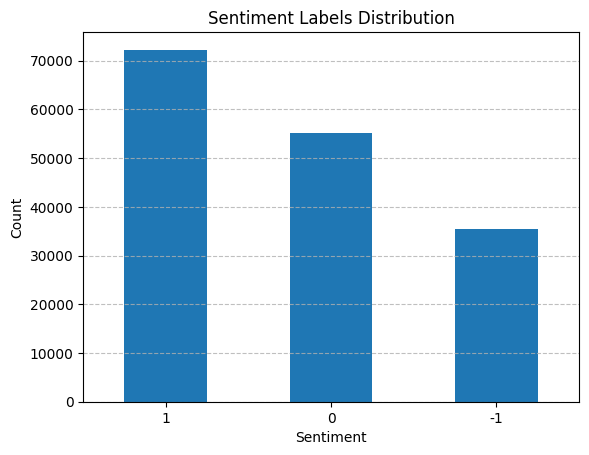

category
 1    72249
 0    55184
-1    35509
Name: count, dtype: int64


In [158]:
count = df["category"].value_counts()

plt.title("Sentiment Labels Distribution")

count.plot(kind="bar")
plt.xlabel("Sentiment")
plt.xticks(rotation=0)

plt.ylabel("Count")

plt.grid(axis="y", linestyle="--", alpha=0.8)  # horizontal lines

plt.show()
print(count)

We can see that there is a noticeable difference between the three classes. The positive class (1) dominates with a count of over 72,000, the neutral class (0) is in the middle with a count around 55,000, and the negative class (-1) has the lowest count of around 35,000.

Let's look at the proportions of the three classes to get a clearer picture.


In [159]:
proportions = df["category"].value_counts(normalize=True)
print(proportions)

category
 1    0.443403
 0    0.338673
-1    0.217924
Name: proportion, dtype: float64


- Positive is about 44% of the data
- Neutral is about 34% of the data
- Negative is about 22% of the data

This imbalance is not relevant for now, as the rest of this section focuses on preprocessing the data. We'll take note of this for later when evaluating the models.

Let's now examine the size of the vocabulary to understand the range of words in our dataset and why keeping it manageable is important.


In [160]:
all_words = df["clean_ours"].str.split().explode()

# Count unique words
unique_words_count = all_words.nunique()

print("Number of unique words:", unique_words_count)

Number of unique words: 98694


Even after cleaning, the dataset's vocabulary is still quite large. Reducing it helps focus on meaningful words, avoids bias from rare terms, and keeps the numerical representation compact for machine learning models. To further reduce the vocabulary without losing relevant information, we can apply **lemmatization**, which converts words to their base or dictionary form.


For `lemmatization`, we use the SpaCy's `en_core_web_sm` version 3.8.0, which is a pretrained language model for English <u>(Honnibal et al., 2020)</u>.


In [161]:
# df["lemmatized"] = df["clean_ours"].progress_apply(lemmatizer)
# df.to_csv("../data/data_post_lemma.csv", index=False)

# Uncomment this after running lemmatization cell once
df = pd.read_csv("../data/data_post_lemma.csv")
df["lemmatized"] = df["lemmatized"].astype(
    "string"
)  # Since its deaful is object, change it to a string

In [162]:
all_words = df["lemmatized"].str.split().explode()

# Count unique words
unique_words_count = all_words.nunique()

print("Number of unique words:", unique_words_count)

Number of unique words: 89509


From **98694** to **89509**, the `lemmatizatizer` was able to reduce the vocabulary by 9185 words.

Let's check out 10 examples to see if it worked.


In [163]:
df[["clean_ours", "lemmatized"]].head(10)

,clean_ours,lemmatized
0,when modi promised minimum government maximum governance expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples,when modi promise minimum government maximum governance expect he begin the difficult job reform the state why do take year get justice state should and not business and should exit psus and temple
1,talk all the nonsense and continue all the drama will vote for modi,talk all the nonsense and continue all the drama will vote for modi
2,what did just say vote for modi welcome bjp told you rahul the main campaigner for modi think modi should just relax,what do just say vote for modi welcome bjp tell you rahul the main campaigner for modi think modi should just relax
3,asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars,ask his supporter prefix chowkidar their name modi do great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuse be come from chowkidar
4,answer who among these the most powerful world leader today trump putin modi may,answer who among these the most powerful world leader today trump putin modi may
5,kiya tho refresh maarkefir comment karo,kiya tho refresh maarkefir comment karo
6,surat women perform yagna seeks divine grace for narendra modi become again,surat woman perform yagna seek divine grace for narendra modi become again
7,this comes from cabinet which has scholars like modi smriti and hema time introspect,this come from cabinet which have scholar like modi smriti and hema time introspect
8,with upcoming election india saga going important pair look current modi leads govt elected with deal brexit combination this weekly looks juicy bears imho,with upcoming election india saga go important pair look current modi lead govt elect with deal brexit combination this weekly look juicy bear imho
9,gandhi was gay does modi,gandhi be gay do modi


We can see that it worked for words such as "seeks", "scholars", and "lead".

To be 100% sure, we can check for examples that end in "-edly" and "-ully".


In [164]:
errors = df[df["lemmatized"].str.contains("edly|ully")]

errors[["clean_ours", "lemmatized"]].head(10)

,clean_ours,lemmatized
629,after modi removed your name from voter list allegedly calls people pretending radio channel via,after modi remove your name from voter list allegedly call people pretend radio channel via
813,after modi removed your name from voter list allegedly calls people ask who they will vote for pretending radio channel,after modi remove your name from voter list allegedly call people ask who they will vote for pretend radio channel
1026,country where modi face and the unabashedly hubristic main bhi chowkidar slogan everywhere frankly nice see humility and teamwork compassion leader,country where modi face and the unabashedly hubristic main bhi chowkidar slogan everywhere frankly nice see humility and teamwork compassion leader
1083,called his mother jersey cow and him hybrid calf what you expect back modi has single handedly dragged down the level political discourse india,call his mother jersey cow and he hybrid calf what you expect back modi have single handedly drag down the level political discourse india
1244,when comes telangana whole heartedly supported trs when comes india then one and only modi,when come telangana whole heartedly support trs when come india then one and only modi
1259,hopefully modi will snyasi,hopefully modi will snyasi
1699,society needs modi governor kalyan singh channels bjp karyakarta rajasthan governor kalyan singh has unabashedly praised prime minister narendra modi and said his reelection necessity for the country and the society,society need modi governor kalyan singh channel bjp karyakarta rajasthan governor kalyan singh have unabashedly praise prime minister narendra modi and say his reelection necessity for the country and the society
1800,year gujarat modi was offered the deputy chief minister bjp leader but rejected the offer saying was going fully responsible for gujarat not all was his decisiveness that made him the chief minister gujarat,year gujarat modi be offer the deputy chief minister bjp leader but reject the offer say be go fully responsible for gujarat not all be his decisiveness that make he the chief minister gujarat
1859,drag this jds mla the road guve him taste public justice and then should modi modi repeatedly even you dislike modi because who the hell stop people from having their personal choices elections,drag this jds mla the road guve he taste public justice and then should modi modi repeatedly even you dislike modi because who the hell stop people from have their personal choice election
1886,have nri friends who hate work with muslims refuse buy from shops run muslims cancel uber the driver has muslim name and purposefully give bad reviews screw them over you cannot put words the damage modi has done such hatred now normal,have nri friend who hate work with muslim refuse buy from shop run muslim cancel uber the driver have muslim name and purposefully give bad review screw they over you can not put word the damage modi have do such hatred now normal


We can see that there are words that were not lemmatized such as "allegedly", "unabashedly", and "hopefully". This is due to the limitation of the model that we are using, which does not seem to fully take in adverbs as something to be lemmatized. Further work can be done to improve on this issue, but for now, this is an error that we acknowledge.


We can reduce the vocabulary (and row count) even further without losing relevant infromation, and it is by removing **stop words**. But by removing stop words, we also reduce the number of words in a tweet.

Before removing the stop words let us look at the length of the tweets.


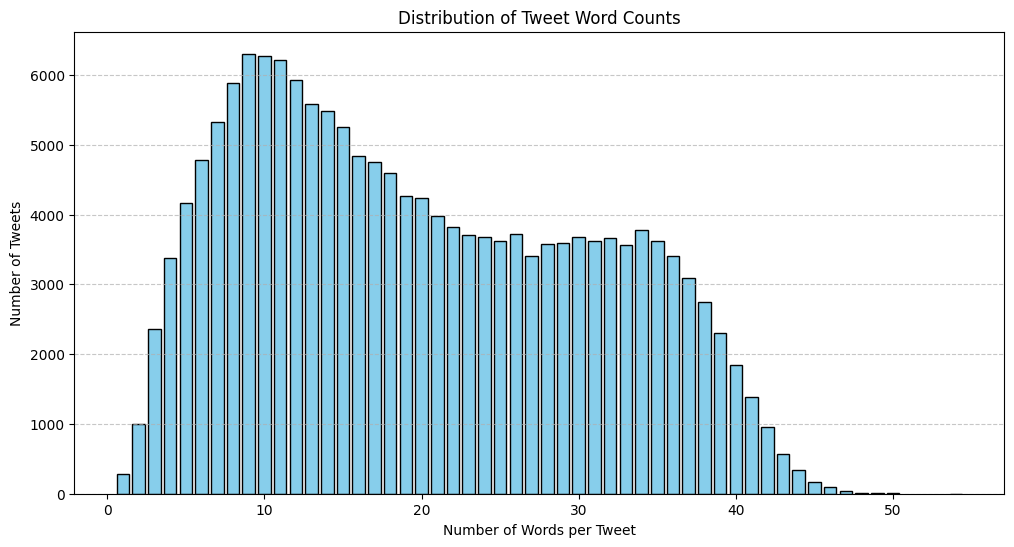

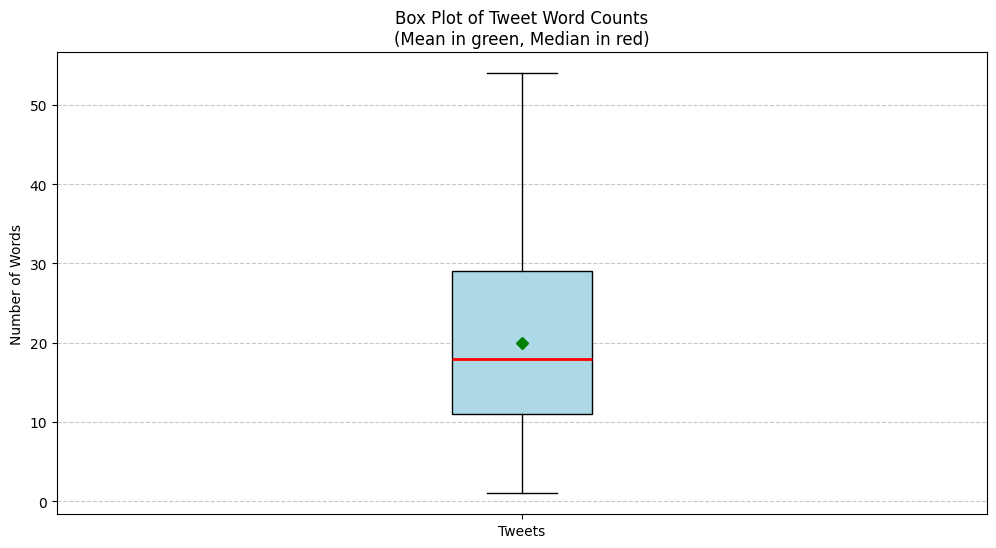

count    162942.000000
mean         19.914957
std          10.842125
min           1.000000
25%          11.000000
50%          18.000000
75%          29.000000
max          54.000000
Name: lemmatized, dtype: float64


In [165]:
# Function to count words in a string, ignoring punctuation
def count_words(text):
    # Remove punctuation using regex
    text_clean = re.sub(r"[^\w\s]", "", text)  # keep only letters, numbers, whitespace
    # Split by whitespace and count words
    return len(text_clean.split())


# Compute number of words for each tweet
word_counts = df["lemmatized"].apply(count_words)

# Count number of tweets for each word count
counts = word_counts.value_counts().sort_index()

# Plot vertical bar chart
plt.figure(figsize=(12, 6))
plt.bar(x=counts.index, height=counts.values, color="skyblue", edgecolor="black")
plt.xlabel("Number of Words per Tweet")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweet Word Counts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Create box plot
plt.figure(figsize=(12, 6))
box = plt.boxplot(
    word_counts,
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
    medianprops=dict(color="red", linewidth=2),
    showmeans=True,
    meanprops=dict(marker="D", markeredgecolor="green", markerfacecolor="green"),
)
plt.ylabel("Number of Words")
plt.title("Box Plot of Tweet Word Counts\n(Mean in green, Median in red)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([1], ["Tweets"])  # Optional label for x-axis
plt.show()

print(word_counts.describe())

We can see that most tweets in the dataset are short to medium in length, typically between 10 and 30 words, with a median of 18 words; there are very few extremely short (1 word) or long (50+ words) tweets, and overall the lengths are fairly consistent with no significant outliers.


The stopword removal **needs** to be after lemmatization since this step requires all words to be reduces to their base dictionary form, and the `stopword_set` only considers base dictionary forms of the stopwords.

**stopwords.** For stop words removal, we refer to the English stopwords dataset defined in NLTK and Wolfram Mathematica <u>(Bird & Loper, 2004; Wolfram Research, 2015)</u>. However, since the task is sentiment analysis, words that invoke polarity, intensification, and negation are important. Words like "not" and "okay" are commonly included as stopwords. Therefore, the stopwords from <u>(Bird & Loper, 2004; Wolfram Research, 2015)</u> are manually adjusted to only include stopwords that invoke neutrality, examples are "after", "when", and "you."


In [166]:
df["lemmatized"] = df["lemmatized"].map(lambda t: rem_stopwords(t, stopwords_set))
df.loc[df["lemmatized"].fillna("").str.len() == 0, "lemmatized"] = np.nan

df = df.dropna()
all_words = df["lemmatized"].str.split().explode()

unique_words_count = all_words.nunique()

print("Number of unique words:", unique_words_count)

Number of unique words: 88995


From **89509** to **88995**, after applying `rem_stopwords` we were able to reduce the vocabulary by 514 words.


Let's look at the length of the tweets in the dataset again, and check if there are any changes.


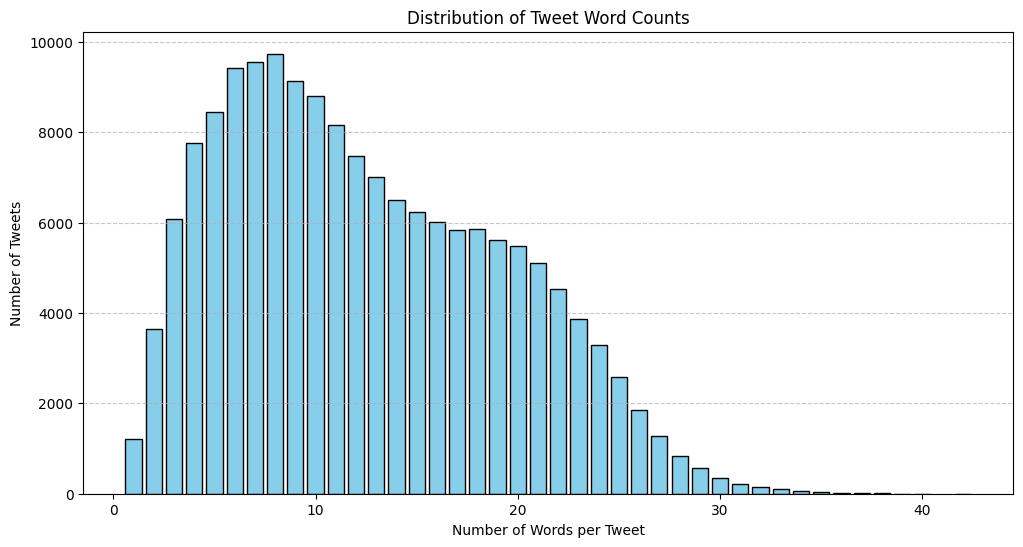

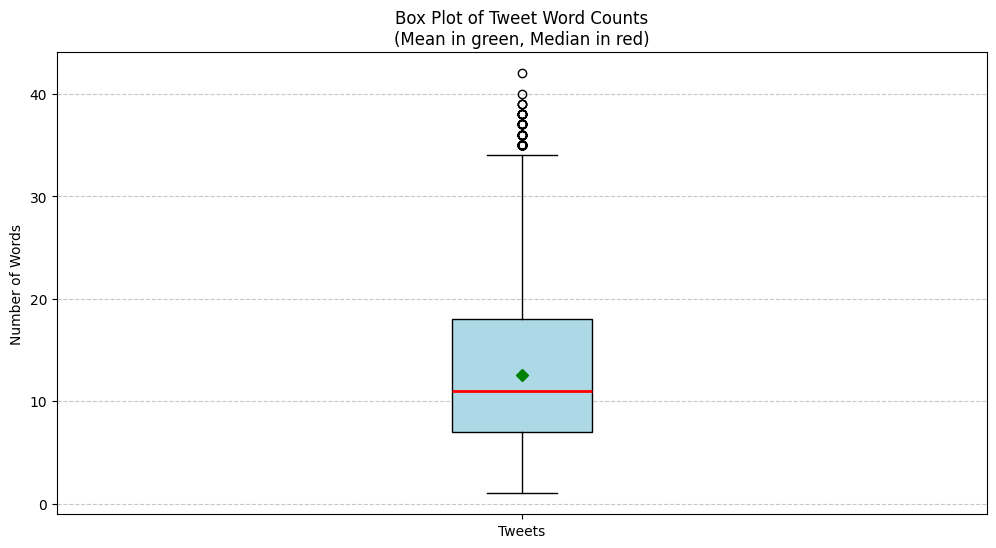

count    162801.000000
mean         12.501397
std           6.806551
min           1.000000
25%           7.000000
50%          11.000000
75%          18.000000
max          42.000000
Name: lemmatized, dtype: float64


In [167]:
# Function to count words in a string, ignoring punctuation
def count_words(text):
    # Remove punctuation using regex
    text_clean = re.sub(r"[^\w\s]", "", text)  # keep only letters, numbers, whitespace
    # Split by whitespace and count words
    return len(text_clean.split())


# Compute number of words for each tweet
word_counts = df["lemmatized"].apply(count_words)

# Count number of tweets for each word count
counts = word_counts.value_counts().sort_index()

# Plot vertical bar chart
plt.figure(figsize=(12, 6))
plt.bar(x=counts.index, height=counts.values, color="skyblue", edgecolor="black")
plt.xlabel("Number of Words per Tweet")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweet Word Counts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Create box plot
plt.figure(figsize=(12, 6))
box = plt.boxplot(
    word_counts,
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
    medianprops=dict(color="red", linewidth=2),
    showmeans=True,
    meanprops=dict(marker="D", markeredgecolor="green", markerfacecolor="green"),
)
plt.ylabel("Number of Words")
plt.title("Box Plot of Tweet Word Counts\n(Mean in green, Median in red)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([1], ["Tweets"])  # Optional label for x-axis
plt.show()

print(word_counts.describe())

After stopword removal, several changes in the data distribution are apparent. Looking at the histogram, there is a noticeable decrease in tweets with lengths of 30–40 words, reflecting the shortening effect of both lemmatization and stopword removal. The peak of the distribution shifted slightly from 9 to 8 words, with a substantial increase in frequency around this new peak, indicating that many tweets are now concentrated in the short-to-medium length range.

The boxplot shows the emergence of outliers, corresponding to extremely short tweets that remain after stopword removal. The overall distribution has shifted further to the left, reflecting the reduced length of most tweets, while these outliers represent unusually long tweets—common in social media data.

The number of rows decreased slightly, from **162,942** to **162,801**, as tweets consisting entirely of stopwords were removed. Additionally, the mean, spread, and maximum tweet length all decreased, showing a tighter and more consistent distribution.


Since the text preprocessing is now complete, we can show the evolution of the data through three stages:<br>

**Uncleaned text** – the original raw tweets<br>
**Cleaned text** – after initial cleaning, such as removing URLs, mentions, and punctuation<br>
**Cleaned** + preprocessed text – after lemmatization and stopword removal<br>

Displaying these three columns side by side illustrates how the tweets have been transformed at each step.


In [168]:
display(df[["clean_text", "clean_ours", "lemmatized"]].sample(10))

,clean_text,clean_ours,lemmatized
80234,this hilarious and professional from,this hilarious and professional from,hilarious professional
1558,that was state elections and for modi can’ loose 2019 will surely come back indians have better choice only one option that shree narendra modi ✌️,that was state elections and for modi can loose will surely come back indians have better choice only one option that shree narendra modi,state election modi loose surely back indians choice only option shree narendra modi
75719,congrats modi sir for this huge acheivement which make pride and proud for drive love you sir jai hind,congrats modi sir for this huge acheivement which make pride and proud for drive love you sir jai hind,congrat modi sir huge acheivement pride proud drive love sir jai hind
56319,dont appreciate this modi intention was different decision based the intention behind makes wrong right was doing this for himself two wrong cant make right advani bad person then cant make modi good,dont appreciate this modi intention was different decision based the intention behind makes wrong right was doing this for himself two wrong cant make right advani bad person then cant make modi good,appreciate modi intention different decision base intention behind wrong right wrong right advani bad person modi good
88710,who ever making comments against modi did you forget won the world cup for 1983,who ever making comments against modi did you forget won the world cup for,ever comment modi forget win cup
27319,some your party wanted modi out fast until death remember,some your party wanted modi out fast until death remember,party modi fast death remember
119910,congress leader mocks modi gets trolled instead,congress leader mocks modi gets trolled instead,congress leader mock modi troll
36937,follower great who spent 15cr samosa 80k 2hrs for drinks 15000 per plate dinner etc etc modi spent travelling brought business and maintain relations wid countries whts wrong tht,follower great who spent samosa hrs for drinks per plate dinner etc etc modi spent travelling brought business and maintain relations wid countries whts wrong tht,follower great spend samosa hrs drink plate dinner modi spend travel bring business maintain relation wid country wht wrong tht
82244,understand people have problems with modi but tell the credibility alternatives please,understand people have problems with modi but tell the credibility alternatives please,understand people problem modi credibility alternative please
77566,think you need study before twiting anything agreed this was done drdo scientists not modi but its allowed modi government and same has been not allowed upa government,think you need study before twiting anything agreed this was done drdo scientists not modi but its allowed modi government and same has been not allowed upa government,need study twit agree drdo scientist modi allow modi government allow upa government


In [169]:
df_cleaned = df.copy()
df_cleaned = df_cleaned.drop(["clean_text", "clean_ours"], axis=1)

df_cleaned = df_cleaned[["lemmatized", "category"]]  # for column reordering
df_cleaned["lemmatized"] = df_cleaned["lemmatized"].astype("string")

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162801 entries, 0 to 162941
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   lemmatized  162801 non-null  string
 1   category    162801 non-null  int64 
dtypes: int64(1), string(1)
memory usage: 3.7 MB


The text is now ready for **feature extraction**, which will convert it into numerical representations for modeling.


We have two options for feature extraction: **Bag of Words (BoW)** and **TF-IDF**.

For our dataset, **BoW** seems to have the edge over TF-IDF.

While both methods count word occurrences, TF-IDF additionally downweights words that appear frequently across the corpus. Normally, common words can be a problem for BoW, but since stopwords have already been removed, this is not an issue here. Furthermore, our corpus is very domain-specific, so certain key terms naturally appear often, and TF-IDF could inadvertently reduce their importance. With stopwords removed and a focused domain, BoW keeps the most relevant words front and center, making it a strong choice for this task.


Before delving into the BoW, we provide a brief overview of how it works.


#### **Tokenization**

Since the data cleaning and preprocessing stage is comprehensive, the tokenization step in the BoW model reduces to a simple word-boundary split operation. Each preprocessed entry in the DataFrame is split by spaces. For example, the entry `"shri narendra modis"` (entry: 42052) becomes `["shri", "narendra", "modis"]`. By the end of tokenization, all entries are transformed into arrays of strings.

#### **Word Bigrams**

As noted earlier, modifiers and polarity words are not included in the stopword set. The BoW model constructs a vocabulary containing both unigrams and bigrams. Including bigrams allows the model to capture common word patterns, such as

$$
\left\langle \texttt{Adj}\right\rangle \left\langle \texttt{M} \mid \texttt{Pron} \right\rangle
$$

<center>or</center>

$$
\left\langle \texttt{Adv}\right\rangle \left\langle \texttt{V} \mid \texttt{Adj} \mid \texttt{Adv} \right\rangle
$$

#### **Vector Representation**

After the stemming and lemmatization steps, each entry can now be represented as a vector using a Bag of Words (BoW) model. We employ scikit-learn's `CountVectorizer`, which provides a ready-to-use implementation of BoW <u>(Pedregosa et al., 2011)</u>.

A comparison of other traditional vector representations are discussed in [this appendix](#appendix:-comparison-of-traditional-vectorization-techniques).
Words with modifiers have the modifiers directly attached, enabling subsequent models to capture the concept of modification fully. Consequently, after tokenization and bigram construction, the vocabulary size can grow up to $O(n^2)$, where $n$ is the number of unique tokens.

#### **minimum document frequency constraint:**

Despite cleaning and spam removal, some tokens remain irrelevant or too rare. To address this, a minimum document frequency constraint is applied: $\texttt{min\_df} = 10$, meaning a token must appear in at least 10 documents to be included in the BoW vocabulary. This reduces noise and ensures the model focuses on meaningful terms.

---

These parameters of the BoW model are encapsulated in the `BagOfWordsModel` class. The class definition is available in [this appendix](#appendix:-BagOfWordsModel-class-definition).


In [170]:
bow = BagOfWordsModel(
    texts=df_cleaned["lemmatized"],  # list of words to include in the model
    min_freq=10,  # words must appear in at least 10 different documents to be included
)

# some sanity checks
assert (
    bow.matrix.shape[0] == df_cleaned.shape[0]
), "number of rows in the matrix DOES NOT matches the number of documents"
assert bow.sparsity, "the sparsity is TOO HIGH, something went wrong"

a:\College\Year 3\Term 2\STINTSY\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


The error above is normal, remember that our tokenization step essentially reduced into an array split step. With this, we need to set the `tokenizer` function attribute of the `BagOfWordsModel` to not use its default tokenization pattern. That causes this warning.


To get an idea of the model, we will now look at its shape and sparsity.<br>

**Shape** - The number of documents and tokens present in the model<br>
**Sparsity** - The number of elements in a matrix that are zero, calculating how sparse or varied the words are in the dataset.


The resulting model has a shape of


In [171]:
n_documents, n_tokens = bow.matrix.shape
print("Bag-of-Words matrix shape:", bow.matrix.shape)

Bag-of-Words matrix shape: (162801, 29318)


The first entry of the pair is the number of documents (the ones that remain after all the data cleaning and preprocessing steps) and the second entry is the number of tokens (or unique words in the vocabulary).

The resulting model has a sparsity of


In [172]:
print("Sparsity:", 1 - bow.sparsity)

Sparsity: 0.9994874290499591


The model is 99.95% sparse, meaning the tweets often do not share the same words leading to a large vocabulary.


Now, looking at the most frequent and least frequent terms in the model.


In [173]:
doc_frequencies = np.asarray((bow.matrix > 0).sum(axis=0)).flatten()
freq_order = np.argsort(doc_frequencies)[::-1]
bow.feature_names[freq_order[:50]]

array(['modi', 'india', 'all', 'people', 'bjp', 'like', 'congress',
       'narendra', 'only', 'election', 'vote', 'narendra modi', 'govt',
       'about', 'year', 'time', 'just', 'country', 'good', 'more',
       'modis', 'rahul', 'nation', 'even', 'indian', 'government', 'work',
       'party', 'power', 'minister', 'win', 'need', 'gandhi', 'support',
       'leader', 'modi govt', 'ask', 'space', 'credit', 'prime', 'money',
       'sir', 'back', 'pakistan', 'chowkidar', 'day', 'prime minister',
       'scientist', 'never', 'today'], dtype=object)

We see that the main talking point of the Tweets, which hovers around Indian politics with keywords like "modi", "india", and "bjp". For additional context, "bjp" referes to the _Bharatiya Janata Party_ which is a conservative political party in India, and one of the two major Indian political parties.

To better understand these, we can check the wordcloud generated from the model.


<function matplotlib.pyplot.show(close=None, block=None)>

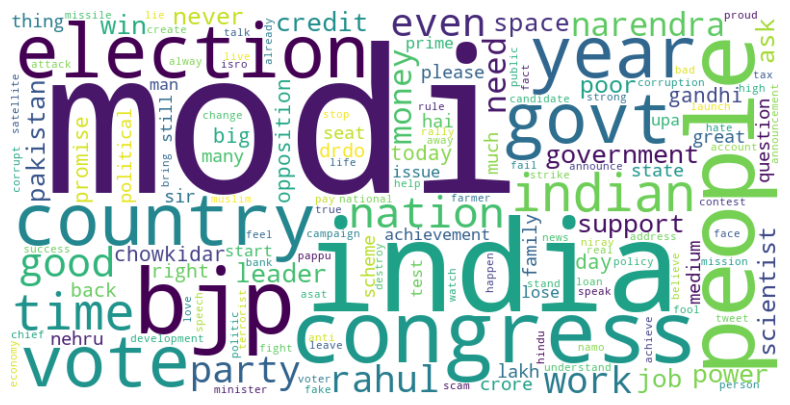

In [174]:
wc = WordCloud(
    width=800, height=400, background_color="white", min_font_size=10
).generate(" ".join(bow.feature_names))
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show

Now, looking at the least popular words.


In [175]:
bow.feature_names[freq_order[-50:]]

array(['wave india', 'wave lose', 'giri', 'girl kidnap', 'good love',
       'transportation', 'trait modi', 'transfer account',
       'goodwill message', 'good service', 'water air', 'good number',
       'goon modi', 'goswami republic', 'gesture modi', 'good stop',
       'government attack', 'government build', 'abcd', 'trivialise',
       'zafar', 'able provide', 'able speak', 'able vote', 'able win',
       'abolish article', 'trend twitter', 'travel modi', 'travel train',
       'good even', 'gng', 'goal post', 'good achievement', 'good always',
       'raid minister', 'unnoticed', 'unofficial', 'bhatt aditi',
       'bhi aur', 'bhi berozgar', 'big danger', 'rajan modi',
       'bhupesh baghel', 'bhutan', 'rakhe', 'rally only', 'bhi mumkin',
       'zara', 'yrs people', 'trolled liberal'], dtype=object)

We still see that the themes mentioned in the most frequent terms are still present in this subset. Although, more filler or non-distinct words do appear more often, like "photos", "soft" and "types".

But the present of words like "reelection" and "wars" still point to this subset still being relevant to the main theme of the dataset.


# **4. Dataset Splitting**

Before being able to use the dataset, we need to partition it into three sets:

1. **Training** - used to train the model to learn and change its parameters
2. **Validation** - used to evaluate the model, comparing its predictions to correct answers for hyperparameter tuning
3. **Test** - used to test the model with new, unseen data

The following section will be dedicated solely to splitting the dataset. We will split the dataset with 70% for training, 15% for validation, and 15% for testing as this is a standard partitioning.

## **Splitting the dataset into Training, Validation, and Testing sets**

We'll first split the dataset into 70% and 30% parts by using Scikit-learn's `train_test_split` function. As mentioned earlier, the distribution of categories is imbalanced, so we have to use the function's `stratify` parameter to maintain an even proportion for all sets.


In [176]:
X = bow.matrix
y = df_cleaned["category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=5
)  # 70/30 split

print(X.shape, y.shape)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(162801, 29318) (162801,)
(113960, 29318) (48841, 29318)
(113960,) (48841,)


We now have our two sets for training and testing, but we do not define a separate validation set because `cross_val_predict()` (that will be used later on) performs cross-validation internally, effectively using portions of the training data as validation folds during model evaluation.


Now that we have our split our data we can use these on the models.


## **Balancing (for later)**


As an imbalanced dataset may bias the model towards the majority, we can balance the set by using a method called "undersampling". Undersampling randomly reduces the number of samples of the majority class to balance it with the minority class.


In [177]:
proportions = y.value_counts(normalize=True)
print(proportions)

category
 1    0.443720
 0    0.338180
-1    0.218101
Name: proportion, dtype: float64


In [178]:
rus = RandomUnderSampler(random_state=42)
Xb, yb = rus.fit_resample(X, y)
print(Xb.shape, yb.shape)

(106521, 29318) (106521,)


In [179]:
proportions = yb.value_counts(normalize=True)
print(proportions)

category
-1    0.333333
 0    0.333333
 1    0.333333
Name: proportion, dtype: float64


In [ ]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    Xb, yb, test_size=0.3, stratify=yb, random_state=5
)  # 70/30 split

# will not use Xb_test and yb_test as it is not realistic to have balanced test set in real life.
# they are created here just for the sake of completing the train-test split process.

print(Xb_train.shape, Xb_test.shape)

(74564, 29318) (31957, 29318)


In [181]:
proportions = yb_train.value_counts(normalize=True)
print(proportions)

category
 0    0.333338
-1    0.333338
 1    0.333324
Name: proportion, dtype: float64


# **References**

Bird, S., & Loper, E. (2004, July). NLTK: The natural language toolkit. _Proceedings of the ACL Interactive Poster and Demonstration Sessions_, 214–217. https://aclanthology.org/P04-3031/

El-Demerdash, A. A., Hussein, S. E., & Zaki, J. F. W. (2021). Course evaluation based on deep learning and SSA hyperparameters optimization. _Computers, Materials & Continua, 71_(1), 941–959. https://doi.org/10.32604/cmc.2022.021839

George, M., & Murugesan, R. (2024). Improving sentiment analysis of financial news headlines using hybrid Word2Vec-TFIDF feature extraction technique. _Procedia Computer Science, 244_, 1–8.

Honnibal, M., Montani, I., Van Landeghem, S., & Boyd, A. (2020). spaCy: Industrial-strength Natural Language Processing in Python. https://doi.org/10.5281/zenodo.1212303

Hussein, S. (2021). _Twitter sentiments dataset_. Mendeley.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. _Journal of Machine Learning Research, 12_, 2825–2830.

Rani, D., Kumar, R., & Chauhan, N. (2022, October). Study and comparison of vectorization techniques used in text classification. In _2022 13th International Conference on Computing Communication and Networking Technologies (ICCCNT)_ (pp. 1–6). IEEE.

Wolfram Research. (2015). _DeleteStopwords_. https://reference.wolfram.com/language/ref/DeleteStopwords.html


# **Appendix: `clean` wrapper function definition**

Below is the definition of the `clean` wrapper function that encapsulates all internal functions used in the cleaning pipeline.


In [182]:
clean??

Signature: clean(text: str) -> str
Source:   
def clean(text: str) -> str:
    """
    This is the main function for data cleaning (i.e., it calls all the cleaning functions in the prescribed order).

    This function should be used as a first-class function in a map.

    # Parameters
    * text: The string entry from a DataFrame column.
    * stopwords: stopword dictionary.

    # Returns
    Clean string
    """
    # cleaning on the base string
    text = normalize(text)
    text = rem_punctuation(text)
    text = rem_numbers(text)
    text = collapse_whitespace(text)

    return text
File:      a:\college\year 3\term 2\stintsy\stintsy-order-of-erin\lib\janitor.py
Type:      function

# **Appendix: `find_spam_and_empty` wrapper function definition**

Below is the definition of the `find_spam_and_empty` wrapper function that encapsulates all internal functions for the spam detection algorithm.


In [183]:
find_spam_and_empty??

Signature: find_spam_and_empty(text: str, min_length: int = 3) -> str | None
Source:   
def find_spam_and_empty(text: str, min_length: int = 3) -> str | None:
    """
    Filter out empty text and unintelligible/spammy unintelligible substrings in the text.

    Spammy substrings:
    - Shorter than min_length
    - Containing non-alphabetic characters
    - Consisting of a repeated substring (e.g., 'aaaaaa', 'ababab', 'abcabcabc')

    # Parameters
    * text: input string.
    * min_length: minimum length of word to keep.

    # Returns
        Cleaned string, or None if empty after filtering.
    """
    cleaned_tokens = []
    for t in text.split():
        if len(t) < min_length:
            continue

        if re.search(r"(.)\1{2,}", t):
            continue

        min_diversity = 0.3 + (0.1 * min(len(t), 10) / 10)
        if len(set(t)) / len(t) < min_diversity:
            continue

        if re.match(r"^(.+)\1+", t):
            continue

        cleaned_tokens.append(t)



# **Appendix: comparison of traditional vectorization techniques**

Traditional vectorization techniques include BoW and Term Frequency-Inverse Document Frequency (TF-IDF). TF-IDF weights each word based on its frequency in a document and its rarity across the corpus, reducing the impact of common words. BoW, in contrast, simply counts word occurrences without considering corpus-level frequency. In this project, BoW was chosen because stopwords were already removed during preprocessing, and the dataset is domain-specific <u>(Rani et al., 2022)</u>. In such datasets, frequent words are often meaningful domain keywords, so scaling them down (as TF-IDF would) could reduce the importance of these key terms in the feature representation.


# **Appendix: `BagOfWordsModel` class definition**

Below is the definition of the `BagOfWordsModel` class that encapsulates the desired parameters.


In [184]:
BagOfWordsModel??

Init signature: BagOfWordsModel(texts: Iterable[str], min_freq: int | float | None = None)
Source:        
class BagOfWordsModel:
    """
    A Bag-of-Words representation for a text corpus.

    # Attributes
    * matrix (scipy.sparse.csr_matrix): The document-term matrix of word counts.
    * feature_names (list[str]): List of feature names corresponding to the matrix columns.
    *
    # Usage
    ```
    bow = BagOfWordsModel(df["lemmatized_str"])
    ```
    """

    def __init__(
        self,
        texts: Iterable[str],
        min_freq: int | float | None = None,
    ):
        """
        Initialize the BagOfWordsModel by fitting the vectorizer to the text corpus. This also filters out tokens
        that do not appear more than five times in the dataset.

        This sets its tokenizer to the word boundary tokenizer since the input, at this point, **should** be
        cleaned and processed text.

        This also uses both unigrams and bigrams, hence, at the worst case i